In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [3]:
midwest=pd.read_csv('final data/midwest_stationary.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,23.0
2023-03-21,108.0
2023-03-22,-91.0
2023-03-23,192.0


In [4]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [5]:
west=pd.read_csv('final data/west_stationary.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,37.0
2023-03-21,-4.0
2023-03-22,151.0
2023-03-23,-95.0


# stationary analysis - ALL stationary 

In [6]:
X = east.daily_deaths
result = adfuller(X)
print('East ADF Statistic: %f' % result[0])
print('East p-value: %f' % result[1])
print('East Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = midwest.daily_deaths
result = adfuller(X)
print('Midwest ADF Statistic: %f' % result[0])
print('Midwest p-value: %f' % result[1])
print('Midwest Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = south.daily_deaths
result = adfuller(X)
print('South ADF Statistic: %f' % result[0])
print('South p-value: %f' % result[1])
print('South Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = west.daily_deaths
result = adfuller(X)
print('West ADF Statistic: %f' % result[0])
print('West p-value: %f' % result[1])
print('West Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

East ADF Statistic: -3.842138
East p-value: 0.002504
East Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Midwest ADF Statistic: -6.612100
Midwest p-value: 0.000000
Midwest Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
South ADF Statistic: -3.104854
South p-value: 0.026196
South Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
West ADF Statistic: -5.691688
West p-value: 0.000001
West Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Visualizing the Data

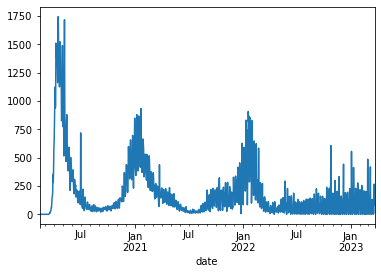

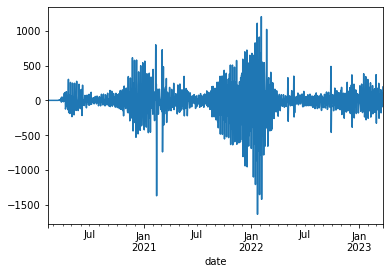

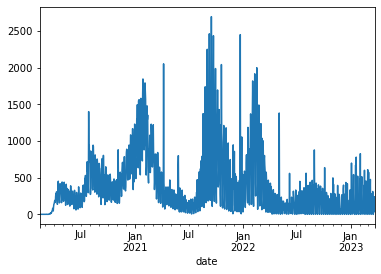

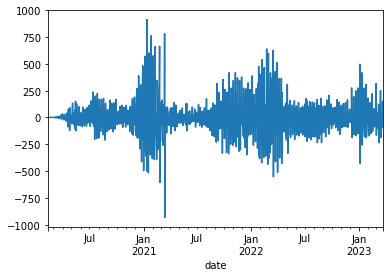

In [8]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [8]:
easttrain = east[east.index < '2023-01-01']
easttest = east[east.index >= '2023-01-01']
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < '2023-01-01']
midwesttest = midwest[midwest.index >= '2023-01-01']
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < '2023-01-01']
southtest = south[south.index >= '2023-01-01']
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < '2023-01-01']
westtest = west[west.index >= '2023-01-01']
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Visualizing data again

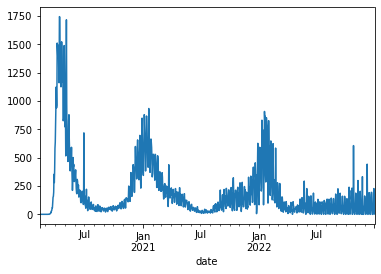

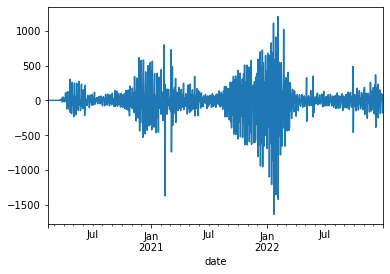

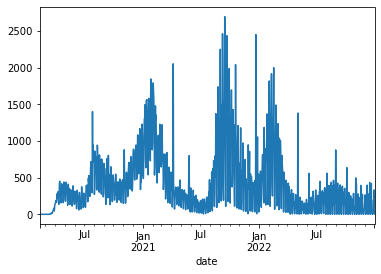

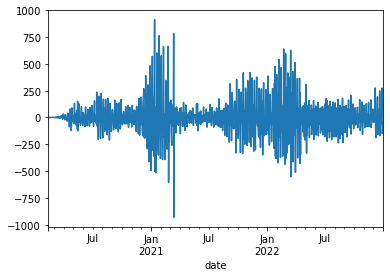

In [10]:
easttrain['daily_deaths'].plot()
plt.show()

midwesttrain['daily_deaths'].plot()
plt.show()

southtrain['daily_deaths'].plot()
plt.show()

westtrain['daily_deaths'].plot()
plt.show()

# Building auto_arima model

using these parameters: East and South best parameters with m = 12 
- yearly seasonality
- with m = 12: Best model:  ARIMA(4,1,2)(2,1,0)[12]

### defining a function for MASE

In [25]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted.iloc[1:].values - Actual.iloc[:-1].values))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

### east

In [151]:
emodel = auto_arima(easttrain, start_p=1, start_q=1,
                           max_p=4, max_q=4, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(emodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13685.019, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13398.902, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13686.288, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13118.244, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13132.165, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13043.563, Time=1.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13332.536, Time=0.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.54 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13022.482, Time=1.54 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

Training Set Metrics:
MAE: 57.240483735179595
MASE: 0.00022950035467864062

Testing Set Metrics:
MAE: 68.69956754467499
MASE: 0.007293657257717211


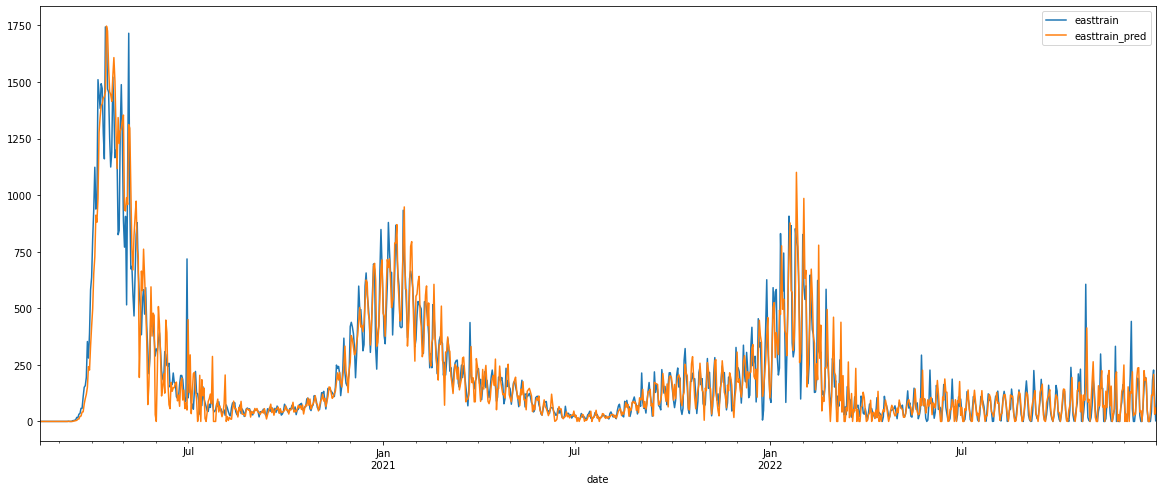

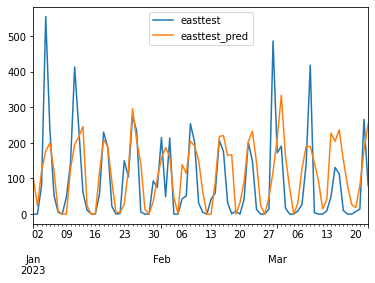

In [153]:
# plot train
easttrain_pred=emodel.fittedvalues()
easttrain_pred = np.maximum(easttrain_pred, 0)
pd.concat([easttrain, easttrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['easttrain', 'easttrain_pred'])

# Calculate metrics for the training set
mae_train = mean_absolute_error(easttrain, easttrain_pred)
mase_train = MASE(easttrain, easttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# plot test
easttest_pred=emodel.predict(n_periods=len(easttest))
easttest_pred = np.maximum(easttest_pred, 0)
pd.concat([easttest, easttest_pred], axis=1).plot()
plt.legend(['easttest', 'easttest_pred'])

# Calculate metrics for the testing set
mae_test = mean_absolute_error(easttest, easttest_pred)
mase_test = MASE(easttest, easttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [154]:
emodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1054
Model:             SARIMAX(4, 1, 2)x(2, 1, [], 12)   Log Likelihood               -6269.438
Date:                             Sat, 17 Feb 2024   AIC                          12556.877
Time:                                     13:56:02   BIC                          12601.408
Sample:                                 02-12-2020   HQIC                         12573.769
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7062      0.021     33.118      0.000       0.664       0.748
ar.L2         -0.7171      0.024    -30.486      0.000      -0.763      -0.671
ar.L3         -0.0433      0.025     -1.733      0.083      -0.092       0.006
ar.L4         -0.4013      0.023    -17.535      0.000      -0.446      -0.356
ma.L1         -1.1816      0.017    -68.679      0.000      -1.215      -1.148
ma.L2          0.7832      0.016     50.235      0.000       0.753       0.814
ar.S.L12      -0.6787      0.019    -35.152      0.000      -0.717      -0.641
ar.S.L24      -0.2511      0.019    -13.058      0.000      -0.289      -0.213
sigma2      9870.8748    207.858     47.489      0.000    9463.481    1.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):              2378.01
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [155]:
n_periods=12
forecast, conf_int = emodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01     98.645176
2023-01-02     23.749724
2023-01-03    121.596842
2023-01-04    177.376113
2023-01-05    199.334066
2023-01-06    121.633667
2023-01-07      8.449854
2023-01-08    -42.852836
2023-01-09     -5.833125
2023-01-10    127.162860
2023-01-11    195.564968
2023-01-12    216.816406
Freq: D, dtype: float64
Confidence Interval: [[ -96.08170716  293.37205912]
 [-196.14301555  243.64246303]
 [-103.82629435  347.01997915]
 [ -58.81141242  413.56363926]
 [ -41.83360359  440.50173581]
 [-126.38078762  369.64812137]
 [-258.99191173  275.89162016]
 [-334.32836416  248.62269215]
 [-315.69402743  304.02777699]
 [-193.03778038  447.36350114]
 [-129.08288335  520.21281965]
 [-111.0747758   544.70758873]]


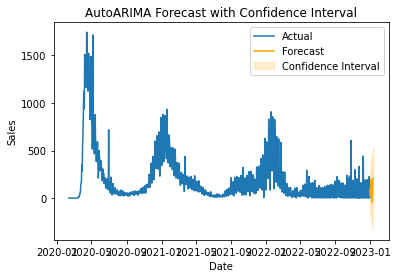

In [156]:
forecast_index = pd.date_range(easttrain.index[-1], periods=n_periods + 1, freq=easttrain.index.freq)[-n_periods:]

plt.plot(easttrain.index, easttrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Midwest
- auto arima selected Best model:  ARIMA(4,1,0)(2,1,0)[12]          

In [48]:
model = auto_arima(midwesttrain, start_p=1, start_q=1,
                           max_p=4, max_q=4, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16030.382, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15379.936, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15814.252, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15244.226, Time=0.92 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15810.247, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15102.582, Time=1.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15306.083, Time=0.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=14873.662, Time=1.86 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

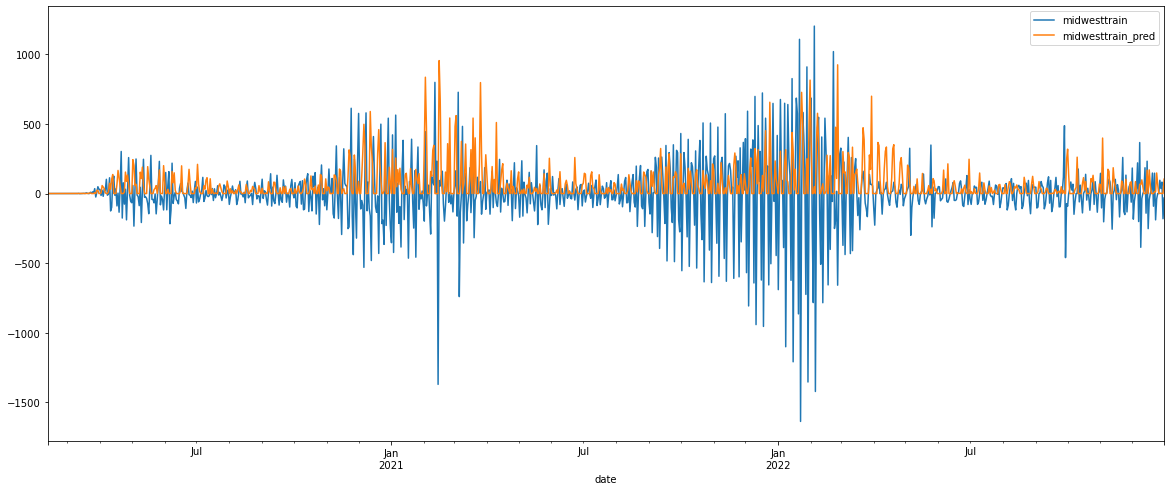

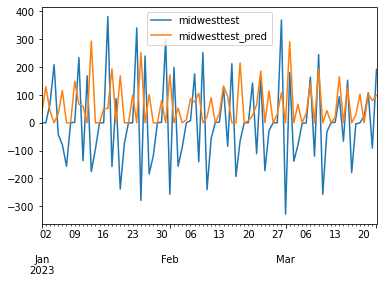

Training Set Metrics:
MAE: 155.64300885855351
MASE: 0.0008627727257366429

Testing Set Metrics:
MAE: 137.59195013231286
MASE: 0.01176419623104879


In [51]:
midwesttrain_pred=model.fittedvalues()
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
pd.concat([midwesttrain, midwesttrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['midwesttrain', 'midwesttrain_pred'])
plt.show()

midwesttest_pred=model.predict(n_periods=len(midwesttest))
midwesttest_pred = np.maximum(midwesttest_pred, 0)
pd.concat([midwesttest, midwesttest_pred], axis=1).plot()
plt.legend(['midwesttest', 'midwesttest_pred'])
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(midwesttrain, midwesttrain_pred)
mase_train = MASE(midwesttrain, midwesttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(midwesttest, midwesttest_pred)
mase_test = MASE(midwesttest, midwesttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1054
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -7366.338
Date:                            Fri, 16 Feb 2024   AIC                          14746.676
Time:                                    17:19:00   BIC                          14781.312
Sample:                                02-12-2020   HQIC                         14759.815
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5190      0.017    -89.015      0.000      -1.552      -1.486
ar.L2         -1.6077      0.032    -50.735      0.000      -1.670      -1.546
ar.L3         -1.1035      0.031    -35.133      0.000      -1.165      -1.042
ar.L4         -0.3723      0.022    -17.141      0.000      -0.415      -0.330
ar.S.L12      -0.5090      0.015    -34.465      0.000      -0.538      -0.480
ar.S.L24      -0.7762      0.014    -57.122      0.000      -0.803      -0.750
sigma2      8.046e+04   1952.633     41.203      0.000    7.66e+04    8.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.75   Jarque-Bera (JB):              2590.80
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### the midwest with east's best parameters:

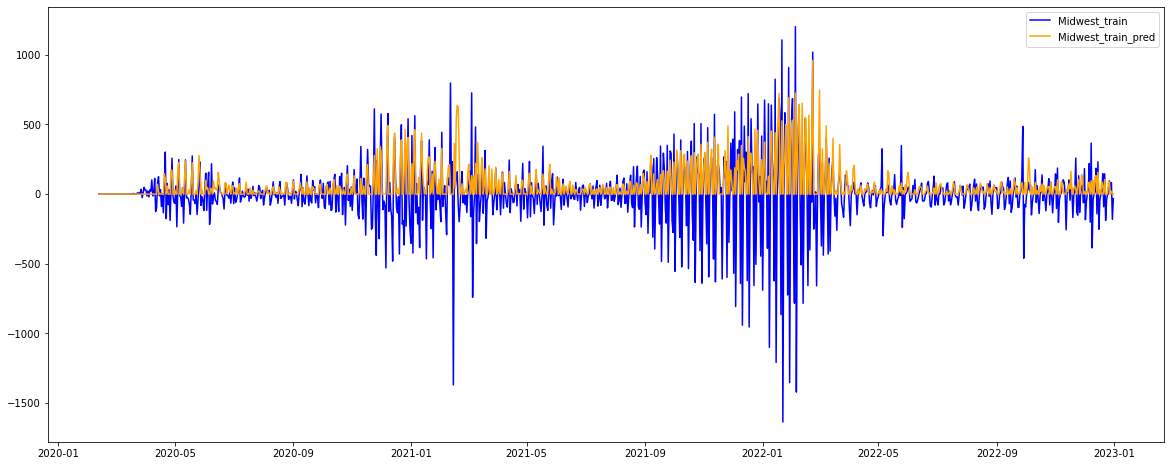

Training Set Metrics:
MAE: 115.15136650668398
MASE: 0.0006409414683258208


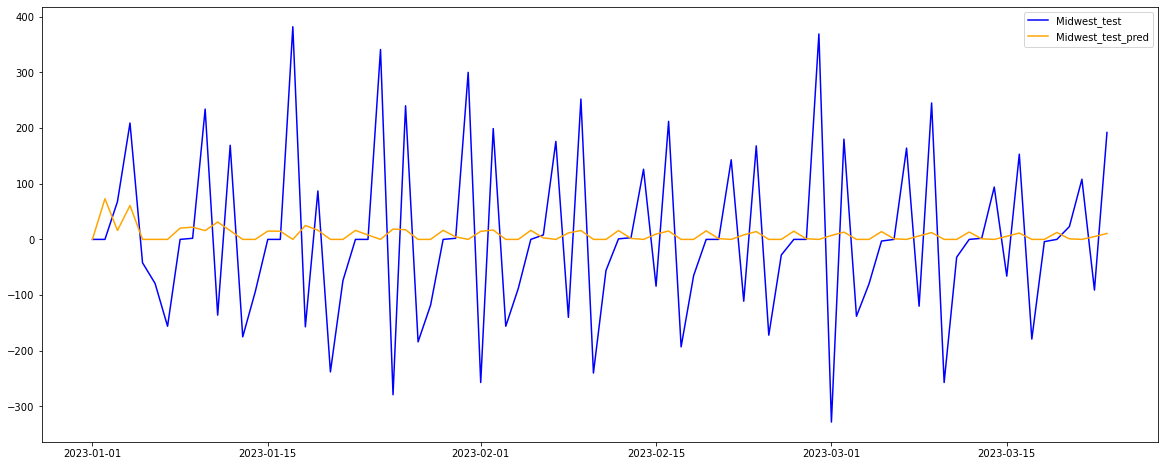


Testing Set Metrics:
MAE: 117.57625502542656
MASE: 0.01231620559404958


In [158]:
# with east chosen parameters
mmodel = auto_arima(midwesttrain, order=(4,1,2), seasonal_order=(2,1,0, 12))
#train
midwesttrain_pred = mmodel.predict_in_sample()

# CLIPPING NEGATIVE PREDICTIONS 
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)

# Plot the train
plt.figure(figsize=(20, 8))
plt.plot(midwesttrain.index, midwesttrain.values, label='Midwest_train', color='blue')
plt.plot(midwesttrain.index, midwesttrain_pred, label='Midwest_train_pred', color='orange')
plt.legend()
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(midwesttrain, midwesttrain_pred)
mase_train = MASE(midwesttrain, midwesttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
midwesttest_pred = mmodel.predict(n_periods = len(midwesttest))

# CLIPPING NEGATIVE PREDICTIONS 
midwesttest_pred = np.maximum(midwesttest_pred, 0)

# Plot the test
plt.figure(figsize=(20, 8))
plt.plot(midwesttest.index, midwesttest.values, label='Midwest_test', color='blue')
plt.plot(midwesttest.index, midwesttest_pred, label='Midwest_test_pred', color='orange')
plt.legend()
plt.show()

# Calculate metrics for the testing set
mae_test = mean_absolute_error(midwesttest, midwesttest_pred)
mase_test = MASE(midwesttest, midwesttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [159]:
mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1054
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -6716.682
Date:                Sat, 17 Feb 2024   AIC                          13455.364
Time:                        14:02:19   BIC                          13509.928
Sample:                    02-12-2020   HQIC                         13476.049
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2286      4.215      0.054      0.957      -8.033       8.491
ar.L1         -0.0156      0.034     -0.459      0.646      -0.082       0.051
ar.L2         -0.7755      0.018    -43.694      0.000      -0.810      -0.741
ar.L3         -0.2262      0.045     -5.036      0.000      -0.314      -0.138
ar.L4         -0.2670      0.019    -14.274      0.000      -0.304      -0.230
ar.L5         -0.6380      0.026    -24.802      0.000      -0.688      -0.588
ma.L1         -0.9237      0.036    -25.745      0.000      -0.994      -0.853
ma.L2          1.0112      0.035     28.591      0.000       0.942       1.081
ma.L3         -0.9166      0.036    -25.778      0.000      -0.986      -0.847
ma.L4          0.4485      0.040     11.316      0.000       0.371       0.526
sigma2      2.558e+04    784.314     32.619      0.000     2.4e+04    2.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              2643.14
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [160]:
n_periods=12
forecast, conf_int = mmodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01   -19.536119
2023-01-02    72.977295
2023-01-03    16.036130
2023-01-04    60.891136
2023-01-05    -4.032343
2023-01-06   -57.577284
2023-01-07   -60.361144
2023-01-08    20.245396
2023-01-09    21.972908
2023-01-10    15.784157
2023-01-11    31.214778
2023-01-12    15.636763
Freq: D, dtype: float64
Confidence Interval: [[-333.02781993  293.95558273]
 [-357.13059089  503.08518168]
 [-421.17564413  453.24790432]
 [-395.55786077  517.3401324 ]
 [-465.04118948  456.97650373]
 [-520.18880005  405.03423167]
 [-545.77367503  425.05138644]
 [-465.17195075  505.66274373]
 [-465.00020033  508.94601608]
 [-475.11561343  506.68392713]
 [-459.97622907  522.40578448]
 [-476.91882231  508.19234876]]


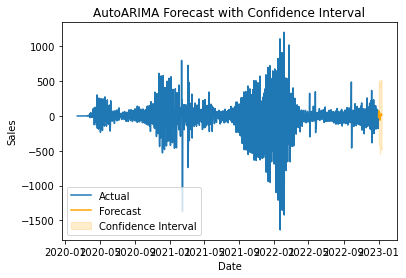

In [161]:
forecast_index = pd.date_range(midwesttrain.index[-1], periods=n_periods + 1, freq=midwesttrain.index.freq)[-n_periods:]

plt.plot(midwesttrain.index, midwesttrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### South

In [162]:
smodel = auto_arima(southtrain, start_p=1, start_q=1,
                           max_p=4, max_q=4, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(smodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15947.000, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15576.090, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15933.654, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15318.450, Time=1.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15369.358, Time=0.70 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15234.402, Time=2.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15535.067, Time=0.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.42 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=15192.853, Time=1.98 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

Training Set Metrics:
MAE: 162.66580602641434
MASE: 0.00036217237843660005

Testing Set Metrics:
MAE: 149.9675132611448
MASE: 0.010872265222854973


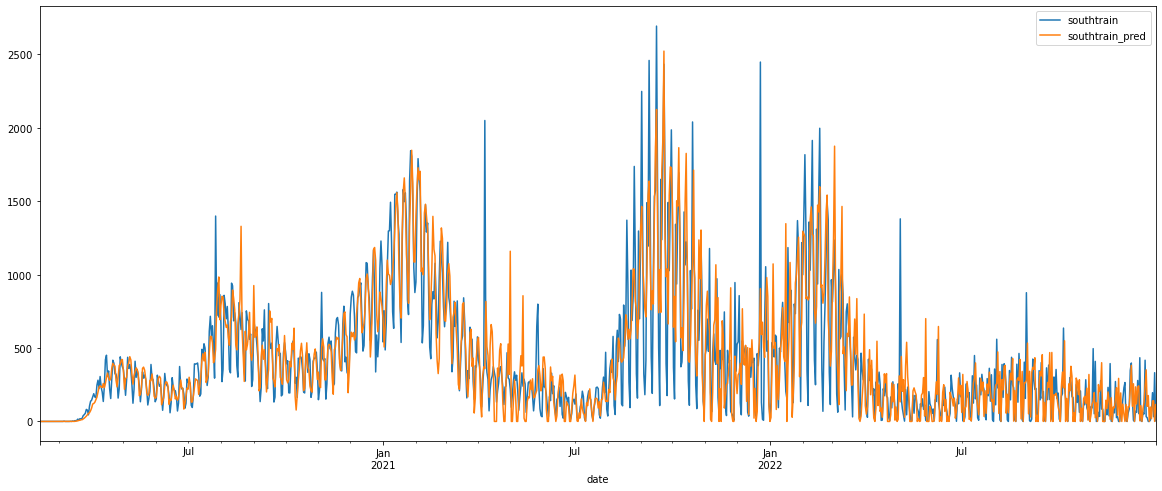

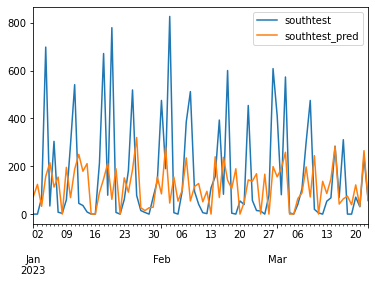

In [163]:
# plot train
southtrain_pred=smodel.fittedvalues()
southtrain_pred = np.maximum(southtrain_pred, 0)
pd.concat([southtrain, southtrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['southtrain', 'southtrain_pred'])

# Calculate metrics for the training set
mae_train = mean_absolute_error(southtrain, southtrain_pred)
mase_train = MASE(southtrain, southtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# plot test
southtest_pred=smodel.predict(n_periods=len(southtest))
southtest_pred = np.maximum(southtest_pred, 0)
pd.concat([southtest, southtest_pred], axis=1).plot()
plt.legend(['southtest', 'southtest_pred'])

# Calculate metrics for the testing set
mae_test = mean_absolute_error(southtest, southtest_pred)
mase_test = MASE(southtest, southtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [164]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1054
Model:             SARIMAX(4, 1, 2)x(2, 1, [], 12)   Log Likelihood               -7251.597
Date:                             Sat, 17 Feb 2024   AIC                          14521.193
Time:                                     14:07:44   BIC                          14565.725
Sample:                                 02-12-2020   HQIC                         14538.085
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4496      0.033     13.791      0.000       0.386       0.513
ar.L2         -0.4340      0.030    -14.539      0.000      -0.493      -0.375
ar.L3         -0.2545      0.031     -8.256      0.000      -0.315      -0.194
ar.L4         -0.4092      0.033    -12.546      0.000      -0.473      -0.345
ma.L1         -1.2235      0.025    -49.891      0.000      -1.272      -1.175
ma.L2          0.7693      0.024     32.422      0.000       0.723       0.816
ar.S.L12      -0.8768      0.031    -28.251      0.000      -0.938      -0.816
ar.S.L24      -0.3172      0.031    -10.378      0.000      -0.377      -0.257
sigma2      7.971e+04   2375.411     33.558      0.000    7.51e+04    8.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   9.83   Jarque-Bera (JB):              1348.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
n_periods=12
forecast, conf_int = smodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01     73.075247
2023-01-02    124.291034
2023-01-03     32.337390
2023-01-04    157.664035
2023-01-05    215.056630
2023-01-06    112.895803
2023-01-07    154.876214
2023-01-08    -85.409300
2023-01-09    195.440001
2023-01-10     68.854357
2023-01-11    187.512268
2023-01-12    249.719441
Freq: D, dtype: float64
Confidence Interval: [[-480.29689185  626.44738597]
 [-443.04567435  691.62774226]
 [-547.15753345  611.8323126 ]
 [-443.49824745  758.82631826]
 [-389.54028314  819.65354326]
 [-518.00263798  743.7942431 ]
 [-529.83626813  839.58869534]
 [-818.37731598  647.55871618]
 [-573.33614417  964.21614538]
 [-714.65777246  852.36648625]
 [-601.60525885  976.62979509]
 [-547.37804908 1046.8169318 ]]


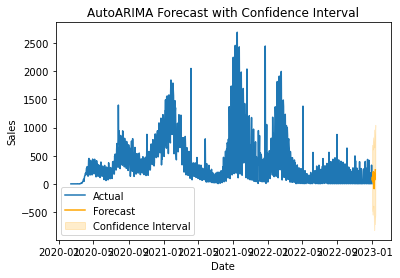

In [166]:
forecast_index = pd.date_range(southtrain.index[-1], periods=n_periods + 1, freq=southtrain.index.freq)[-n_periods:]

plt.plot(southtrain.index, southtrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### west

In [79]:
model = auto_arima(westtrain, start_p=1, start_q=1,
                           max_p=4, max_q=4, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15069.270, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14563.215, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14913.194, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=14365.674, Time=1.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=14731.217, Time=0.52 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=14236.762, Time=1.26 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14526.070, Time=0.62 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=14045.792, Time=1.82 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

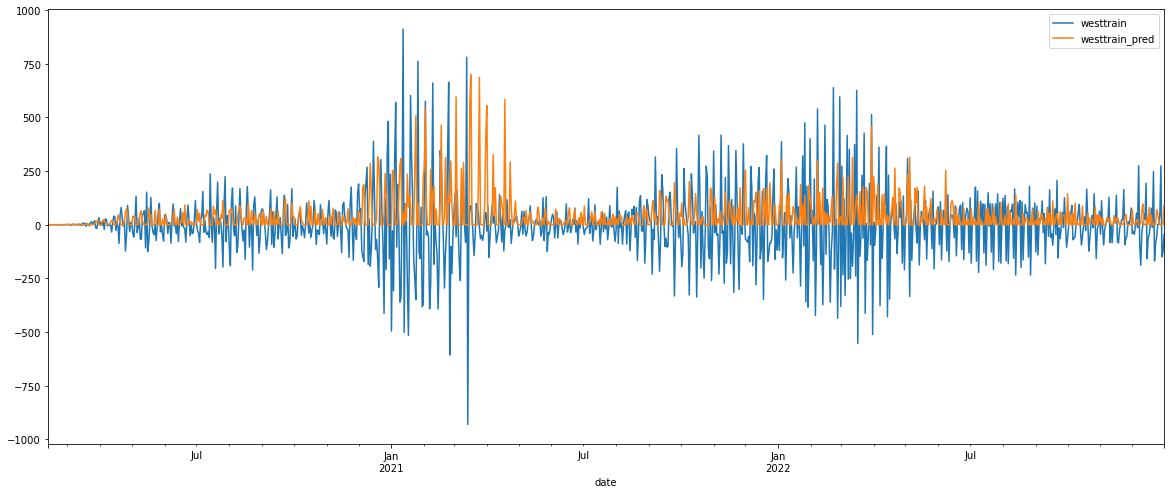

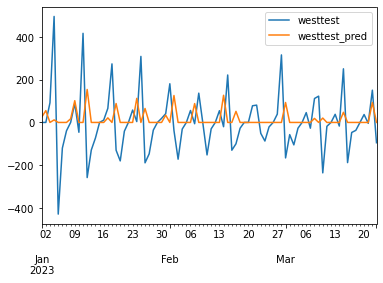

Training Set Metrics:
MAE: 117.2597168041767
MASE: 0.0009229557214599786

Testing Set Metrics:
MAE: 100.30002384936024
MASE: 0.012438285948132424


In [80]:
westtrain_pred=model.fittedvalues()
westtrain_pred = np.maximum(westtrain_pred, 0)
pd.concat([westtrain, westtrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['westtrain', 'westtrain_pred'])
plt.show()

westtest_pred=model.predict(n_periods=len(westtest))
westtest_pred = np.maximum(westtest_pred, 0)
pd.concat([westtest, westtest_pred], axis=1).plot()
plt.legend(['westtest', 'westtest_pred'])
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(westtrain, westtrain_pred)
mase_train = MASE(westtrain, westtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(westtest, westtest_pred)
mase_test = MASE(westtest, westtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1054
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6996.618
Date:                            Fri, 16 Feb 2024   AIC                          14007.235
Time:                                    17:50:45   BIC                          14041.871
Sample:                                02-12-2020   HQIC                         14020.373
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2235      0.023    -53.679      0.000      -1.268      -1.179
ar.L2         -1.1907      0.034    -35.398      0.000      -1.257      -1.125
ar.L3         -0.7321      0.034    -21.845      0.000      -0.798      -0.666
ar.L4         -0.2031      0.026     -7.700      0.000      -0.255      -0.151
ar.S.L12      -0.5513      0.018    -31.360      0.000      -0.586      -0.517
ar.S.L24      -0.7588      0.013    -57.267      0.000      -0.785      -0.733
sigma2      3.952e+04   1151.543     34.319      0.000    3.73e+04    4.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               357.36
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.10
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## with east and south best parameters

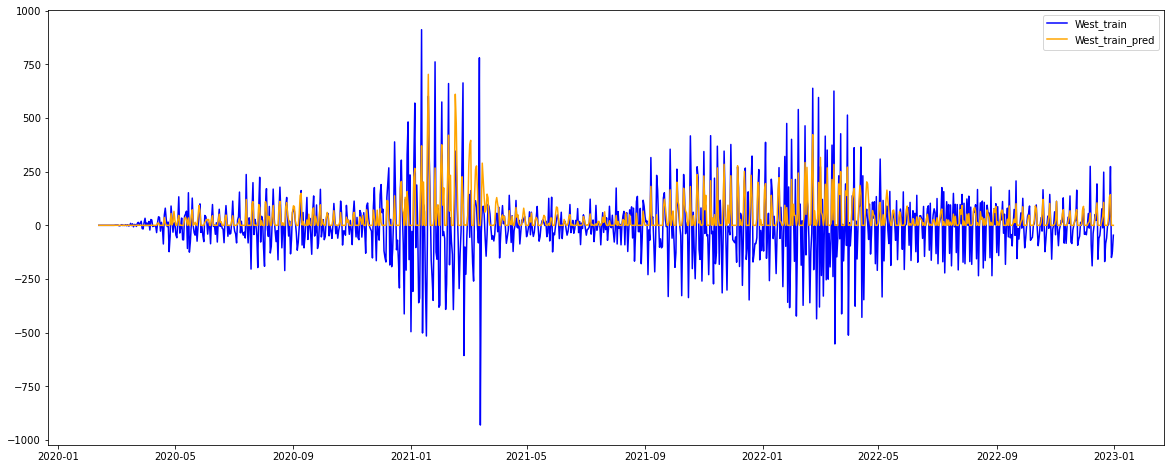

Training Set Metrics:
MAE: 84.9324231920635
MASE: 0.0006805163729821516


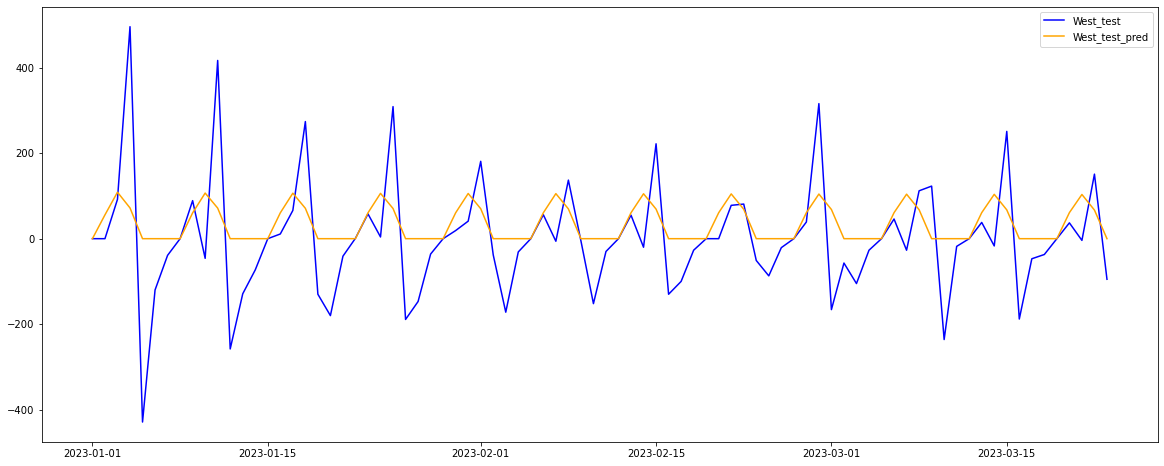


Testing Set Metrics:
MAE: 87.71326042329194
MASE: 0.010047446318838046


In [167]:
# with east and south's parameters
wmodel = auto_arima(westtrain, order=(4,1,2), seasonal_order=(2,1,0, 12))
#train
westtrain_pred = wmodel.predict_in_sample()

# CLIPPING NEGATIVE PREDICTIONS 
westtrain_pred = np.maximum(westtrain_pred, 0)

# Plot the train
plt.figure(figsize=(20, 8))
plt.plot(westtrain.index, westtrain.values, label='West_train', color='blue')
plt.plot(westtrain.index, westtrain_pred, label='West_train_pred', color='orange')
plt.legend()
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(westtrain, westtrain_pred)
mase_train = MASE(westtrain, westtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# test
westtest_pred = wmodel.predict(n_periods = len(westtest))

# CLIPPING NEGATIVE PREDICTIONS 
westtest_pred = np.maximum(westtest_pred, 0)

# Plot the test
plt.figure(figsize=(20, 8))
plt.plot(westtest.index, westtest.values, label='West_test', color='blue')
plt.plot(westtest.index, westtest_pred, label='West_test_pred', color='orange')
plt.legend()
plt.show()

# Calculate metrics for the testing set
mae_test = mean_absolute_error(westtest, westtest_pred)
mase_test = MASE(westtest, westtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [168]:
wmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1054
Model:               SARIMAX(3, 0, 5)   Log Likelihood               -6357.706
Date:                Sat, 17 Feb 2024   AIC                          12735.412
Time:                        14:14:12   BIC                          12785.015
Sample:                    02-12-2020   HQIC                         12754.217
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.1287      0.623     -1.812      0.070      -2.350       0.092
ar.L1          1.2062      0.162      7.464      0.000       0.889       1.523
ar.L2         -0.9498      0.202     -4.694      0.000      -1.346      -0.553
ar.L3         -0.0395      0.162     -0.244      0.807      -0.357       0.278
ma.L1         -2.0752      0.161    -12.856      0.000      -2.392      -1.759
ma.L2          1.9466      0.346      5.633      0.000       1.269       2.624
ma.L3         -0.6930      0.361     -1.921      0.055      -1.400       0.014
ma.L4         -0.2101      0.191     -1.100      0.271      -0.584       0.164
ma.L5          0.1778      0.040      4.450      0.000       0.099       0.256
sigma2      1.166e+04    286.790     40.647      0.000    1.11e+04    1.22e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              4886.94
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.07
Prob(H) (two-sided):                  0.50   Kurtosis:                        13.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
n_periods=12
forecast, conf_int = wmodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01    -44.847549
2023-01-02     55.732083
2023-01-03    108.785301
2023-01-04     71.934078
2023-01-05    -18.339395
2023-01-06    -95.871974
2023-01-07   -102.193166
2023-01-08    -32.609503
2023-01-09     60.390068
2023-01-10    106.724916
2023-01-11     71.532667
2023-01-12    -18.600423
Freq: D, dtype: float64
Confidence Interval: [[-256.46104861  166.76595061]
 [-224.61900818  336.08317472]
 [-171.77686928  389.34747138]
 [-208.70402686  352.57218251]
 [-299.6184272   262.93963805]
 [-377.2937182   185.54977043]
 [-385.06200114  180.67566837]
 [-316.73627877  251.51727325]
 [-223.77587624  344.55601228]
 [-178.20159498  391.65142646]
 [-215.03561013  358.10094463]
 [-305.69484391  268.49399884]]


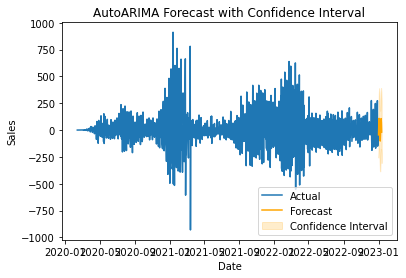

In [170]:
forecast_index = pd.date_range(westtrain.index[-1], periods=n_periods + 1, freq=westtrain.index.freq)[-n_periods:]

plt.plot(westtrain.index, westtrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# combined forecasts

Combined MAE (Training Set): 516.304213180318


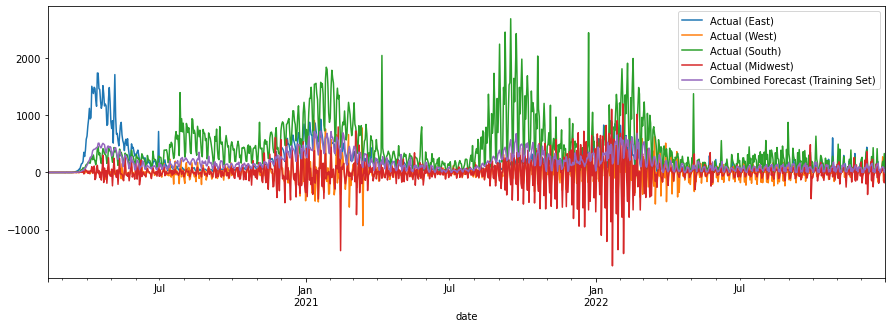

Combined MAE (Test Set): 289.0550375203696


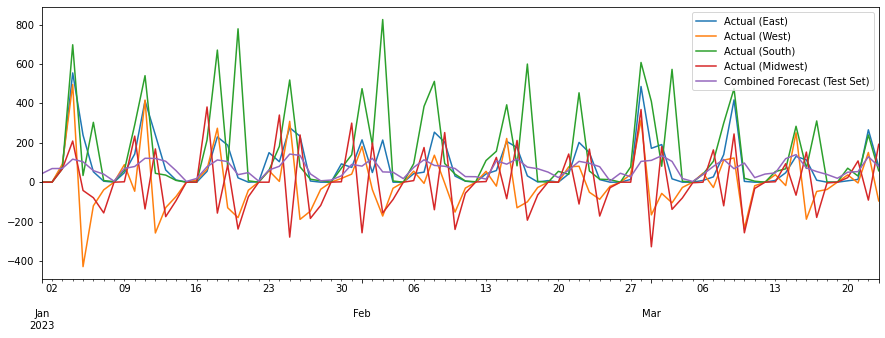

In [171]:
# Combine the forecasts for training set
combined_forecast_train = (easttrain_pred + westtrain_pred + southtrain_pred + midwesttrain_pred) / 4

# Evaluate and fine-tune as needed for training set
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['daily_deaths'].values + midwesttrain['daily_deaths'].values

# Convert the combined forecast to a NumPy array for training set
predicted_values_combined_train = combined_forecast_train.values.flatten()

# Calculate MAE for training set
mae_combined_train = mean_absolute_error(actual_values_combined_train, predicted_values_combined_train)
print(f"Combined MAE (Training Set): {mae_combined_train}")

# Combine actual values for plotting for training set
actual_values_combined_train_df = pd.concat([easttrain['daily_deaths'], westtrain['daily_deaths'], southtrain['daily_deaths'], midwesttrain['daily_deaths']], axis=1)
actual_values_combined_train_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecast for training set
pd.concat([actual_values_combined_train_df, combined_forecast_train], axis=1).plot(figsize=(15, 5))
plt.legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast (Training Set)'])
plt.show()

# Combine the forecasts for test set
combined_forecast_test = (easttest_pred + westtest_pred + southtest_pred + midwesttest_pred) / 4

# Evaluate and fine-tune as needed for test set
actual_values_combined_test = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Convert the combined forecast to a NumPy array for test set
predicted_values_combined_test = combined_forecast_test.values.flatten()

# Calculate MAE for test set
mae_combined_test = mean_absolute_error(actual_values_combined_test, predicted_values_combined_test)
print(f"Combined MAE (Test Set): {mae_combined_test}")

# Combine actual values for plotting for test set
actual_values_combined_test_df = pd.concat([easttest['daily_deaths'], westtest['daily_deaths'], southtest['daily_deaths'], midwesttest['daily_deaths']], axis=1)
actual_values_combined_test_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecast for test set
pd.concat([actual_values_combined_test_df, combined_forecast_test], axis=1).plot(figsize=(15, 5))
plt.legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast (Test Set)'])
plt.show()

# combined mase

In [172]:
def combinedMASE(Actual, Predicted):
    n = len(Actual)

    # Calculate the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(Actual - Predicted))

    # Calculate the denominator for 1D arrays
    denominator = 1 / (n - 1) * np.sum(np.abs(np.diff(Actual)))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# combine the forecasts - train
combined_forecast_train = (easttrain_pred + westtrain_pred + southtrain_pred + midwesttrain_pred) / 4

# Evaluate and fine-tune as needed - train
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['daily_deaths'].values + midwesttrain['daily_deaths'].values

# Convert the combined forecast to a NumPy array - train
predicted_values_combined_mase_train = combined_forecast_train.values.flatten()

# Calculate MASE for combined forecast - train
mase_combined_train = combinedMASE(actual_values_combined_train, predicted_values_combined_mase_train)
print(f"Combined MASE train : {mase_combined_train}")

# Combine the forecasts - test
combined_forecast = (easttest_pred + westtest_pred + southtest_pred + midwesttest_pred) / 4

# Evaluate and fine-tune as needed - test
actual_values_combined = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Convert the combined forecast to a NumPy array - test
predicted_values_combined_mase = combined_forecast.values.flatten()

# Calculate MASE for combined forecast - test
mase_combined = combinedMASE(actual_values_combined, predicted_values_combined_mase)
print(f"Combined MASE test : {mase_combined}")


Combined MASE train : 1.1130047894111494
Combined MASE test : 0.7717280740680291
